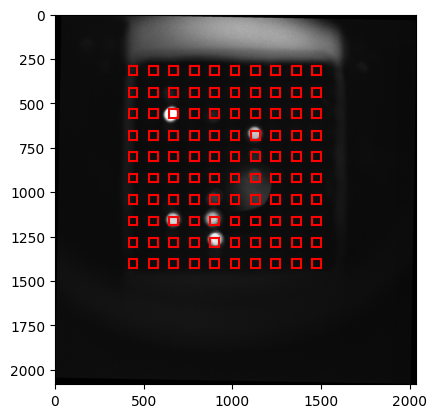

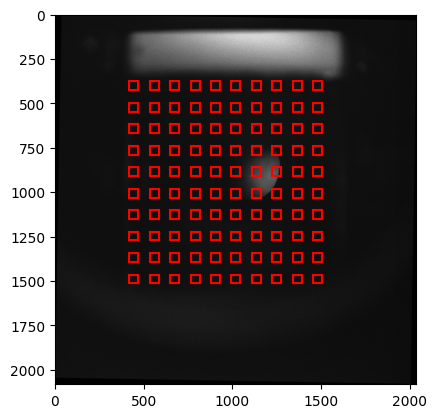

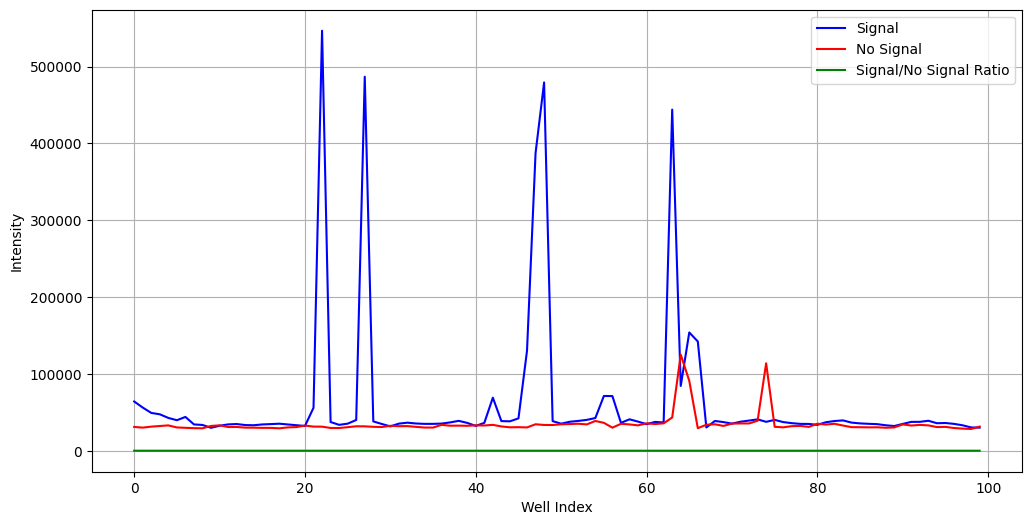

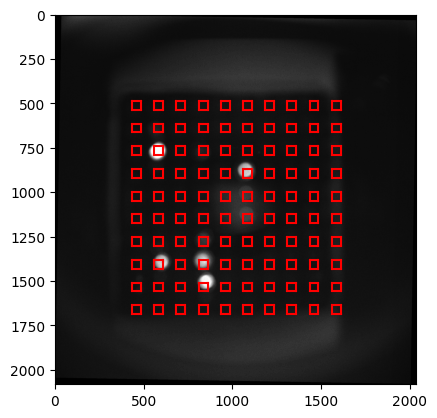

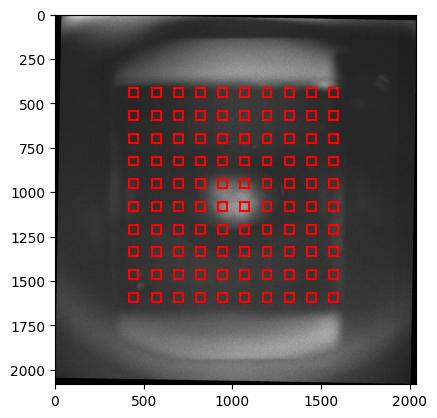

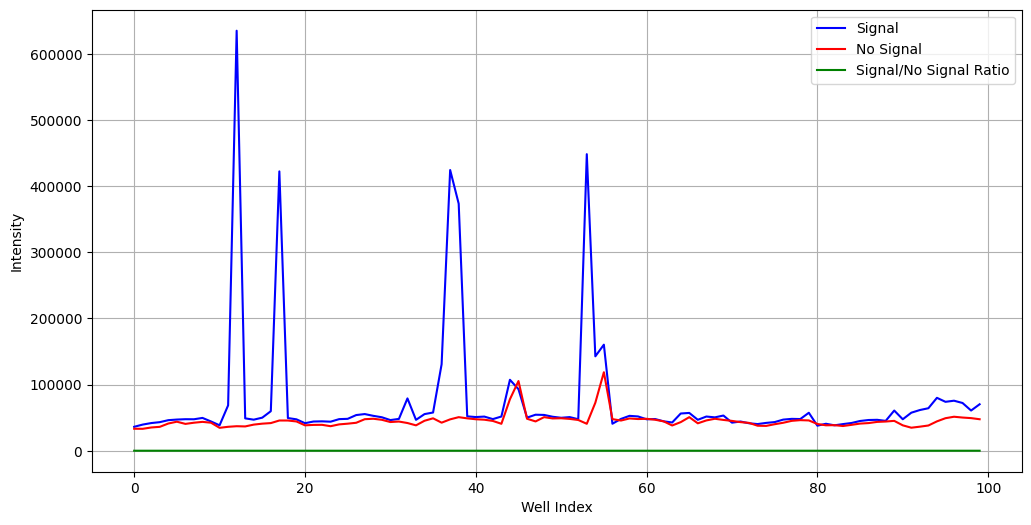

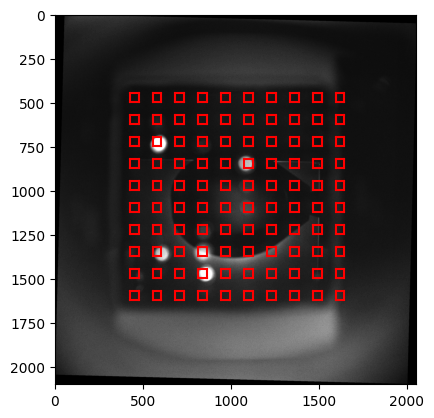

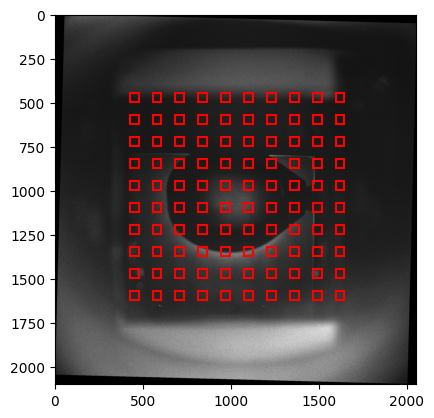

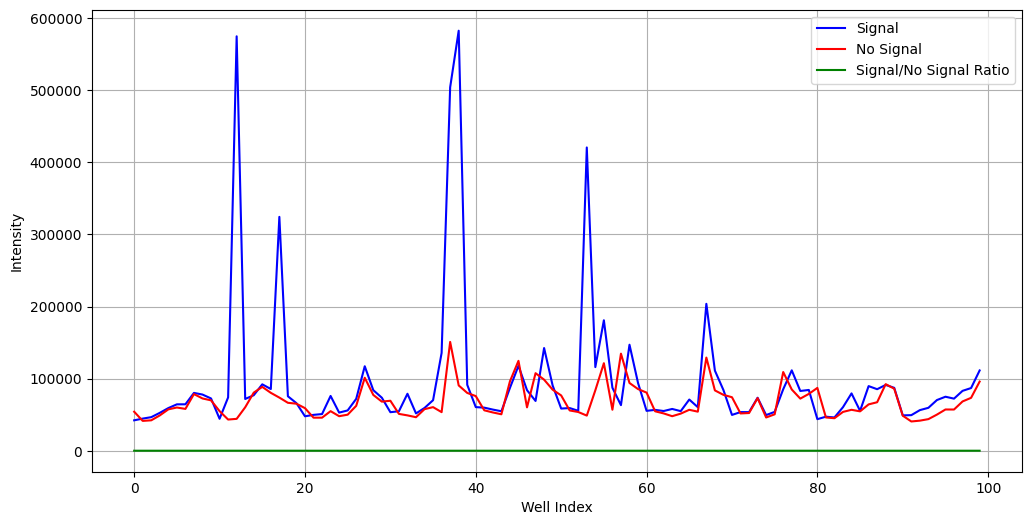

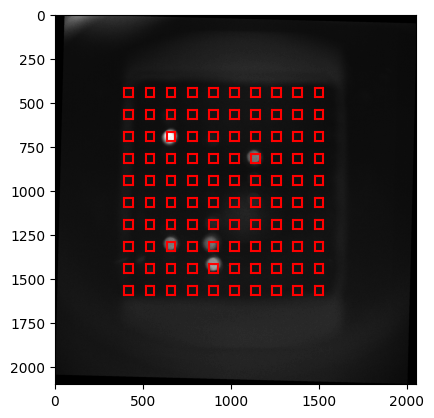

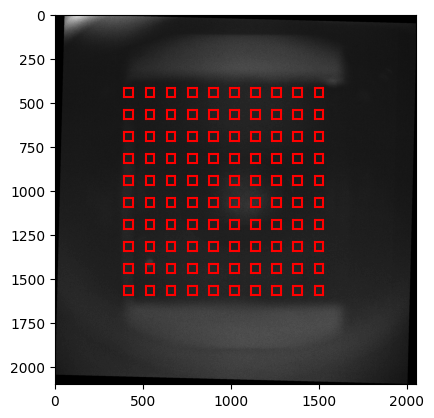

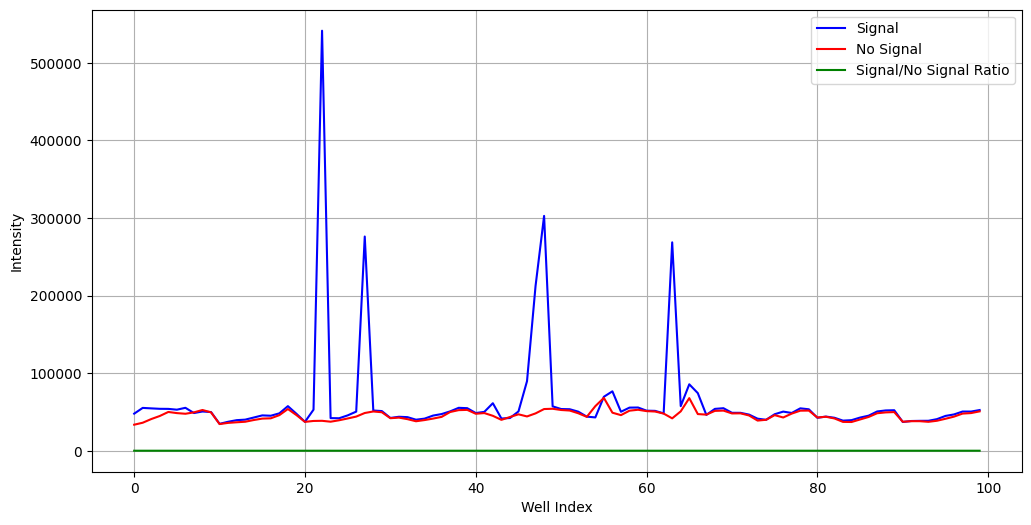

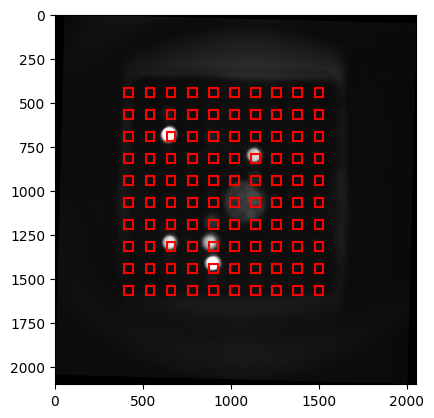

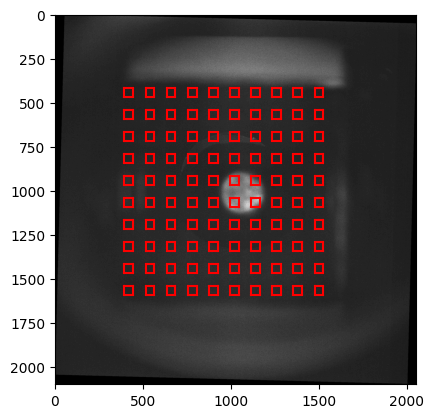

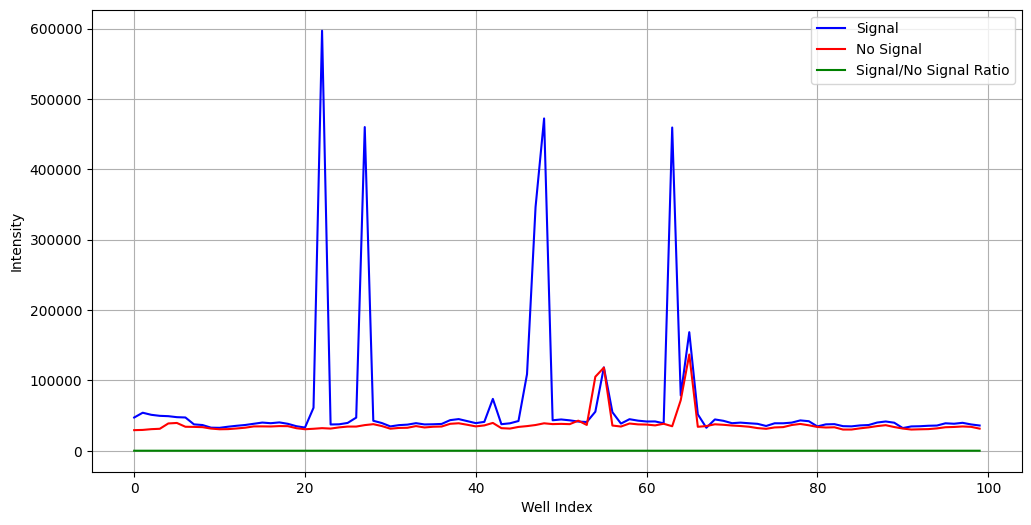

[[2.0683989670755327, 1.8683694170075493, 1.5702070637781962, 1.474001741510138, 1.2951511105716713, 1.3104165291438379, 1.4745262451786014, 1.1646306189811821, 1.1495919906740726, 0.9242936451322767, 0.9838572899630504, 1.1097466139589138, 1.1238471246885213, 1.1116508084370218, 1.1058933395590835, 1.150193374810829, 1.1660664400390428, 1.2062092624356775, 1.126033806715213, 1.079379532372931, 0.9842481225960071, 1.7801102156531712, 17.452789219912507, 1.261492214678961, 1.1406414033661825, 1.1485565160658946, 1.2572542362224528, 15.335076719493367, 1.2264005399672162, 1.1280155642023346, 0.9754414075740301, 1.1048048612416212, 1.1386938750039002, 1.1401808993465736, 1.1585280954748882, 1.1591572660915728, 1.0503492346559666, 1.1312799410391843, 1.1907709278097807, 1.1163127561870128, 0.9771771044586373, 1.10387077110637, 2.049256257237018, 1.2201919118345632, 1.2563740771123872, 1.3740007178516658, 4.293240523867648, 11.247364293805001, 14.297395662420572, 1.1522129186602872, 1.02249

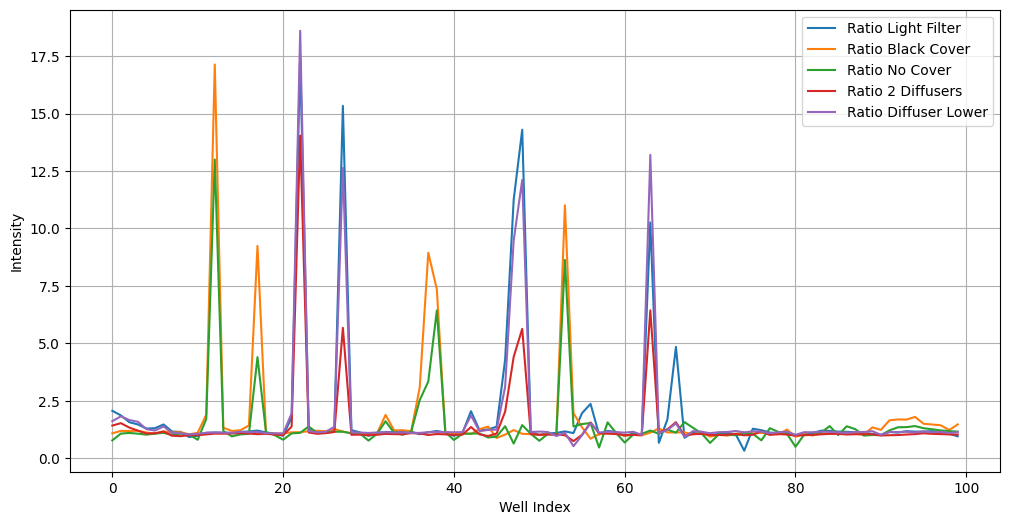

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import tifffile
from scipy.ndimage import rotate

def correct_tilt(image, angle):
    # Rotate the image to correct the tilt
    rotated_image = rotate(image, angle, reshape=True)
    return rotated_image

def draw_box_and_measure_intensity(image, x_coord, y_coord, side_length, box_number, intensity_array, draw=True):
    l = side_length // 2

    if draw:
        plt.plot([x_coord - l, x_coord + l], [y_coord - l, y_coord - l], c='r')
        plt.plot([x_coord - l, x_coord + l], [y_coord + l, y_coord + l], c='r')
        plt.plot([x_coord - l, x_coord - l], [y_coord - l, y_coord + l], c='r')
        plt.plot([x_coord + l, x_coord + l], [y_coord - l, y_coord + l], c='r')
        # plt.text(x_coord + 30, y_coord + 30, str(box_number), c='r')

    box = image[y_coord - l:y_coord + l, x_coord - l:x_coord + l]
    intensity = np.sum(box.flatten())
    intensity_array.append(intensity)

def view_boxes_on_image(image, coords_list, side_length=50, well_num=None):
    plt.imshow(image, cmap='gray')

    intensity_array = []
    num = 0
    for coords in coords_list:
        if well_num is not None:
            draw = num in well_num
            draw_box_and_measure_intensity(image, coords[0], coords[1], side_length, num, intensity_array, draw=draw)
        else:
            draw_box_and_measure_intensity(image, coords[0], coords[1], side_length, num, intensity_array)
        num += 1

    plt.show()
    return intensity_array

def image_intensity(image_path, well_num, side_length, start_well, difference_x, difference_y, tilt_angle, alpha, beta):
    wells = []
    for i in range(10):  # Adjust the range based on the number of rows and columns
        well_x = start_well[0] + difference_x * i
        for j in range(10):
            well_y = start_well[1] + difference_y * j
            wells.append([well_x, well_y])
    
    with tifffile.TiffFile(image_path) as tif:
        image = tif.asarray()
        metadata = tif.pages[0].tags
    image = correct_tilt(image, tilt_angle)
    clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(8, 8))
    clahe_image = clahe.apply(image)

    # alpha = 0.15  # contrast
    # beta = 0   # brightness
    clahe_image = cv2.convertScaleAbs(clahe_image, alpha=alpha, beta=beta)

    intensity_array = view_boxes_on_image(clahe_image, wells, side_length, well_num)

    # Print the intensity array
    return intensity_array

def intensity_ratio(array1, array2):
    ratio = []
    for i in range(len(array1)):
        ratio.append(array1[i] / array2[i])
    return ratio

def plot_signal_single(signal_data, no_signal_data, ratio_data):
    plt.figure(figsize=(12, 6))
    
    # Plot signal data
    plt.plot(signal_data, label='Signal', color='b')
    
    # Plot no-signal data
    plt.plot(no_signal_data, label='No Signal', color='r')
    
    # Plot ratio data
    plt.plot(ratio_data, label='Signal/No Signal Ratio', color='g')
    
    plt.xlabel('Well Index')
    plt.ylabel('Intensity')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_signal_multi(ratio_arr, name_arr):
    plt.figure(figsize=(12, 6))
    
    for i in range(len(ratio_arr)):
        plt.plot(ratio_arr[i], label=f'Ratio {name_arr[i]}')
    
    plt.xlabel('Well Index')
    plt.ylabel('Intensity')
    plt.legend()
    plt.grid(True)
    plt.show()

well_num = [i for i in range(100)]
ratio_arr = []

no_signal_paths = ['images/experiment 8/nosignal_light_filter.tif', 'images/experiment 8/nosignal_black_cover.tif', 'images/experiment 8/nosignal_no_cover.tif', 'images/experiment 8/nosignal_2_diffusers.tif', 'images/experiment 8/nosignal_diffuser_lower.tif']
signal_paths = ['images/experiment 8/signal_light_filter.tif', 'images/experiment 8/signal_black_cover.tif', 'images/experiment 8/signal_no_cover.tif', 'images/experiment 8/signal_2_diffusers.tif', 'images/experiment 8/signal_diffuser_lower.tif']
name_arr = ['Light Filter', 'Black Cover', 'No Cover', '2 Diffusers', 'Diffuser Lower']

signal_data = image_intensity(signal_paths[0], well_num, side_length=50, start_well=[440, 315], difference_x=115, difference_y=121, tilt_angle=-1, alpha=0.15, beta=0)
no_signal_data = image_intensity(no_signal_paths[0], well_num, side_length=50, start_well=[445, 400], difference_x=115, difference_y=121, tilt_angle=-1,alpha=0.15, beta=0)
ratio_data = intensity_ratio(signal_data, no_signal_data)
ratio_arr.append(ratio_data)

plot_signal_single(signal_data, no_signal_data, ratio_data)

signal_data = image_intensity(signal_paths[1], well_num, side_length=50, start_well=[460, 510], difference_x=125, difference_y=128, tilt_angle=-1, alpha=0.15, beta=0)
no_signal_data = image_intensity(no_signal_paths[1], well_num, side_length=50, start_well=[445, 440], difference_x=125, difference_y=128, tilt_angle=-1, alpha=0.15, beta=0)
ratio_data = intensity_ratio(signal_data, no_signal_data)
ratio_arr.append(ratio_data)

plot_signal_single(signal_data, no_signal_data, ratio_data)

signal_data = image_intensity(signal_paths[2], well_num, side_length=50, start_well=[450, 470], difference_x=130, difference_y=125, tilt_angle=-1.5, alpha=0.15, beta=0)
no_signal_data = image_intensity(no_signal_paths[2], well_num, side_length=50, start_well=[450, 470], difference_x=130, difference_y=125, tilt_angle=-1.5, alpha=0.15, beta=0)
ratio_data = intensity_ratio(signal_data, no_signal_data)
ratio_arr.append(ratio_data)

plot_signal_single(signal_data, no_signal_data, ratio_data)

signal_data = image_intensity(signal_paths[3], well_num, side_length=50, start_well=[420, 440], difference_x=120, difference_y=125, tilt_angle=-1.5, alpha=0.15, beta=0)
no_signal_data = image_intensity(no_signal_paths[3], well_num, side_length=50, start_well=[420, 440], difference_x=120, difference_y=125, tilt_angle=-1.5, alpha=0.15, beta=0)
ratio_data = intensity_ratio(signal_data, no_signal_data)
ratio_arr.append(ratio_data)

plot_signal_single(signal_data, no_signal_data, ratio_data)

signal_data = image_intensity(signal_paths[4], well_num, side_length=50, start_well=[420, 440], difference_x=120, difference_y=125, tilt_angle=-1.5, alpha=0.15, beta=0)
no_signal_data = image_intensity(no_signal_paths[4], well_num, side_length=50, start_well=[420, 440], difference_x=120, difference_y=125, tilt_angle=-1.5, alpha=0.15, beta=0)
ratio_data = intensity_ratio(signal_data, no_signal_data)
ratio_arr.append(ratio_data)

plot_signal_single(signal_data, no_signal_data, ratio_data)


print(ratio_arr)
plot_signal_multi(ratio_arr, name_arr)
